# Airbnb Pricing Prediction — Final Project Notebook

This notebook loads the **Airbnb NYC 2019** dataset (`AB_NYC_2019.csv`), performs cleaning and EDA, and trains baseline models to predict nightly price.

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from math import sqrt
import pathlib

FIG_DIR = pathlib.Path('/mnt/data/figures'); FIG_DIR.mkdir(parents=True, exist_ok=True)
DATA_CANDIDATES = [pathlib.Path('AB_NYC_2019.csv'), pathlib.Path('/mnt/data/AB_NYC_2019.csv')]
data_path = next((p for p in DATA_CANDIDATES if p.exists()), None)
if data_path is None:
    print('AB_NYC_2019.csv not found. Creating a small synthetic sample (for demo only).')
    rng = np.random.default_rng(42)
    n = 2000
    df = pd.DataFrame({
        'price': np.clip(rng.lognormal(mean=4.2, sigma=0.6, size=n), 30, 1000),
        'room_type': rng.choice(['Entire home/apt','Private room','Shared room'], size=n, p=[0.55,0.40,0.05]),
        'minimum_nights': rng.integers(1, 10, size=n),
        'reviews_per_month': np.abs(rng.normal(1.2, 0.8, size=n)),
        'latitude': 40.6 + rng.random(n)*(40.92-40.6),
        'longitude': -74.05 + rng.random(n)*(-73.7 + 74.05),
        'availability_365': rng.integers(0, 365, size=n)
    })
else:
    df = pd.read_csv(data_path)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Clean & Feature Engineering

In [3]:
df = df.copy()
df = df.dropna(subset=['price'])
df = df[df['price'] > 0]
cap = df['price'].quantile(0.99)
df.loc[df['price'] > cap, 'price'] = cap
features = ['room_type','minimum_nights','reviews_per_month','latitude','longitude','availability_365']
df = df.dropna(subset=features)
X, y = df[features], df['price']
numeric_features = ['minimum_nights','reviews_per_month','latitude','longitude','availability_365']
categorical_features = ['room_type']
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(31066, 7767)

## EDA

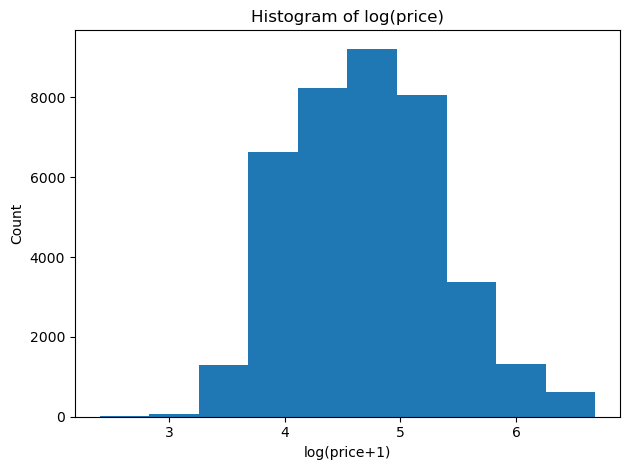

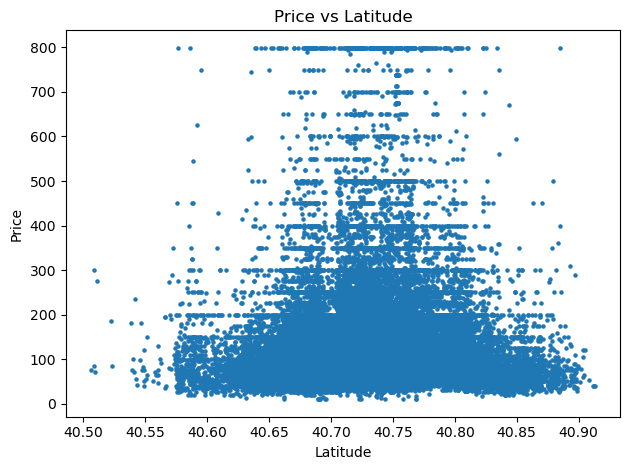

<Figure size 640x480 with 0 Axes>

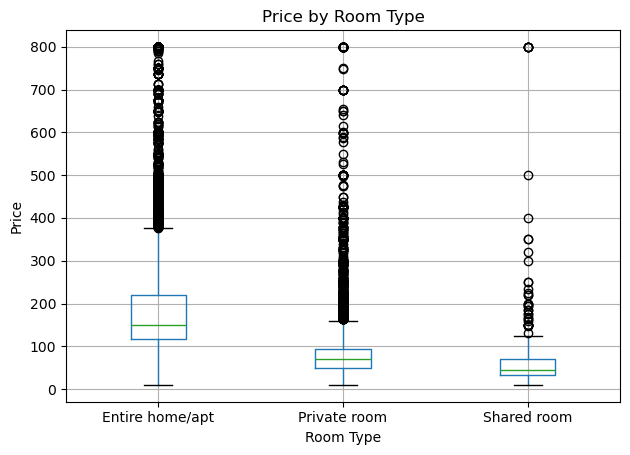

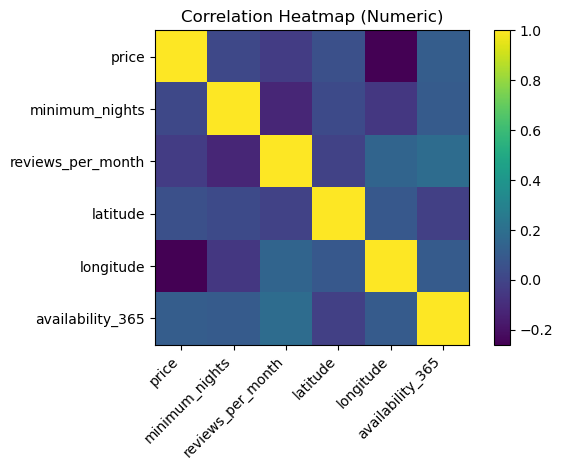

In [5]:
plt.figure(); plt.hist(np.log1p(df['price'])); plt.title('Histogram of log(price)'); plt.xlabel('log(price+1)'); plt.ylabel('Count'); plt.tight_layout(); plt.savefig(FIG_DIR/'hist_log_price.png'); plt.show()
plt.figure(); plt.scatter(df['latitude'], df['price'], s=5); plt.title('Price vs Latitude'); plt.xlabel('Latitude'); plt.ylabel('Price'); plt.tight_layout(); plt.savefig(FIG_DIR/'scatter_price_latitude.png'); plt.show()
plt.figure(); df.boxplot(column='price', by='room_type'); plt.title('Price by Room Type'); plt.suptitle(''); plt.xlabel('Room Type'); plt.ylabel('Price'); plt.tight_layout(); plt.savefig(FIG_DIR/'box_price_roomtype.png'); plt.show()
corr = df[['price'] + numeric_features].corr(); plt.figure(); plt.imshow(corr, interpolation='nearest'); plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right'); plt.yticks(range(len(corr.index)), corr.index); plt.title('Correlation Heatmap (Numeric)'); plt.colorbar(); plt.tight_layout(); plt.savefig(FIG_DIR/'heatmap_corr.png'); plt.show()

## Modeling & Evaluation

In [7]:
from math import sqrt
def evaluate(model_name, model):
    pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{model_name:25s} | RMSE={rmse:.2f}  MAE={mae:.2f}  R2={r2:.3f}")
    return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2}
results = []
results.append(evaluate('Ridge', Ridge(alpha=1.0)))
results.append(evaluate('Lasso', Lasso(alpha=0.01)))
results.append(evaluate('RandomForest', RandomForestRegressor(n_estimators=200, random_state=42)))
results.append(evaluate('GradientBoosting', GradientBoostingRegressor(random_state=42)))
import pandas as pd
res_df = pd.DataFrame(results); res_df

Ridge                     | RMSE=95.41  MAE=56.15  R2=0.282
Lasso                     | RMSE=95.41  MAE=56.15  R2=0.282
RandomForest              | RMSE=85.08  MAE=49.02  R2=0.429
GradientBoosting          | RMSE=87.60  MAE=49.69  R2=0.395


,model,rmse,mae,r2
0,Ridge,95.408174,56.148302,0.282019
1,Lasso,95.407933,56.145699,0.282023
2,RandomForest,85.080090,49.017402,0.429051
3,GradientBoosting,87.595312,49.688882,0.394794


## Feature Importance (tree-based example)

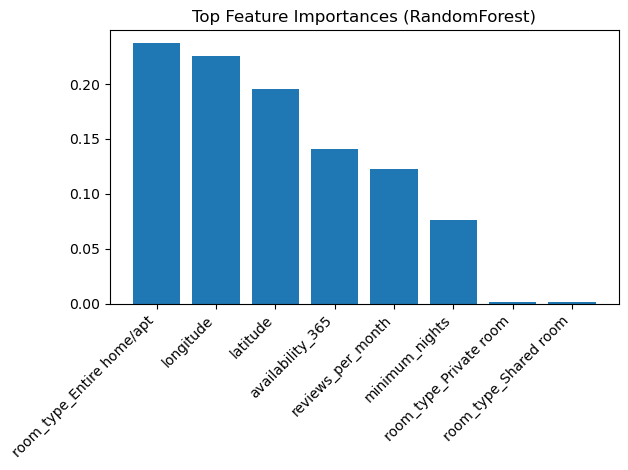

In [8]:
rf = Pipeline(steps=[('prep', preprocess), ('model', RandomForestRegressor(n_estimators=300, random_state=42))])
rf.fit(X_train, y_train)
ohe = rf.named_steps['prep'].transformers_[1][1]
ohe_features = list(ohe.get_feature_names_out(categorical_features))
final_features = numeric_features + ohe_features
import numpy as np, matplotlib.pyplot as plt
importances = rf.named_steps['model'].feature_importances_
order = np.argsort(importances)[::-1][:10]
plt.figure(); plt.bar(range(len(order)), importances[order]); plt.xticks(range(len(order)), [final_features[i] for i in order], rotation=45, ha='right'); plt.title('Top Feature Importances (RandomForest)'); plt.tight_layout(); plt.savefig(FIG_DIR/'feature_importance_rf.png'); plt.show()